# Sentence Pair Classification

In [3]:
import os
import sys
import logging
import torch
import numpy as np
import argparse
from math import exp

from torch import nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from random import random as rand


from transformers import BertTokenizer, BertForNextSentencePrediction
from transformers import AutoTokenizer, AutoModelForMaskedLM,AutoModel
#import sentence_pair_utils
#import sentence_pair_evaluation
import transformers
import pandas as pd

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

import random

2025-03-12 12:44:02.485879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 12:44:02.644044: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 12:44:03.161481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-03-12 12:44:03.161556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

cuda


In [325]:
!nvidia-smi

Fri Mar 14 13:03:24 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:21:00.0 Off |                    0 |
| N/A   31C    P0    24W / 250W |      4MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transformers.logging.set_verbosity_error()

LOG_FORMAT = '%(asctime)s : %(filename)s : %(funcName)s : %(levelname)s : %(message)s'
logging.basicConfig(filename='SentencePairCLS-5fold.log', level=logging.INFO, format=LOG_FORMAT)
logger = logging.getLogger("SentencePairCLS")

In [6]:
import pickle
def pkl_vars(varname, filename):
    with open(filename, 'wb') as file:
        pickle.dump(varname, file)
        
def reload_vars(filename):
    this_var = None
    with open(filename, 'rb') as file:
        this_var = pickle.load(file)      
    return this_var

## Dataset prepation

In [6]:
df_flattened_dd = pd.read_csv("parsed_disambiguation_list_without===.csv")
df_flattened_dd.tail()

,dd_page_title,term,definition,def_page_title,categories,plain_text_definition
2102,Definition:Zero,Zero,Let $\mathbb A$ be one of the standard number ...,Definition:Zero Mapping,['Definitions/Mapping Theory'],"Let 𝔸 be one of the standard number systems ℕ,..."
2103,Definition:Zero,Zero,Let $f: R \to R$ be a mapping on a ring $R$.\n...,Definition:Root of Mapping,"['Definitions/Roots of Mappings', 'Definitions...",Let f: R → R be a mapping on a ring R.\n\nLet ...
2104,Definition:Zero,Zero,"Let $\left( R, +_R, \times_R \right)$ be a rin...",Definition:Zero Vector,"['Definitions/Zero Vectors', 'Definitions/Vect...","Let ( R, +_R, ×_R ) be a ring.\n\nLet ( G, +_G..."
2105,Definition:Zero Locus,Zero Locus,Let $k$ be a field.\n\nLet $n\geq1$ be a natur...,Definition:Zero Locus of Set of Polynomials,['Definitions/Algebraic Geometry'],Let k be a field.\n\nLet n≥1 be a natural numb...
2106,Definition:Zero Locus,Zero Locus,Let $A$ be a commutative ring with unity.\n\nL...,Definition:Vanishing Set of Subset of Ring,['Definitions/Zariski Topology'],Let A be a commutative ring with unity.\n\nLet...


In [7]:
df_flattened_dd['term_in_def'] = df_flattened_dd.apply(lambda row: row['term'].lower() in row['plain_text_definition'].lower(), axis=1)
df_flattened_dd[~df_flattened_dd['term_in_def']]

,dd_page_title,term,definition,def_page_title,categories,plain_text_definition,term_in_def
4,Definition:Absolute,Absolute,A constant is a name for an object (usually a ...,Definition:Constant,"['Definitions/Constants', 'Definitions/Algebra']",A constant is a name for an object (usually a ...,False
12,Definition:Absolute,Absolute,Let $S$ be a sample or a population.\n\nLet $\...,Definition:Frequency (Descriptive Statistics),['Definitions/Frequency (Descriptive Statistic...,Let S be a sample or a population.\n\nLet ω be...,False
29,Definition:Additive Function,Additive Function,Let $R$ be a unique factorization domain.\n\nL...,Definition:Additive Function on UFD,['Definitions/Ring Theory'],Let R be a unique factorization domain.\n\nLet...,False
33,Definition:Additive Function,Additive Function,Let $\unicode{x3a3}$ be a $\sigma$-algebra.\n\...,Definition:Countably Additive Function,"['Definitions/Set Systems', 'Definitions/Measu...",Let x3a3 be a σ-algebra.\n\nLet f: x3a3→R be a...,False
52,Definition:Adjacent Faces,Adjacent Faces,":\n\nLet $G = \left( V, E \right)$ be a planar...",Definition:Adjacent (Graph Theory)/Faces,"['Definitions/Adjacency (Graph Theory)', 'Defi...",":\n\nLet G = ( V, E ) be a planar graph.\n\nTw...",False
...,...,...,...,...,...,...,...
2067,Definition:Vertex,Vertex,Consider a cone consisting of the set of all s...,Definition:Cone (Geometry)/Apex,"['Definitions/Cones', 'Definitions/Apices']",Consider a cone consisting of the set of all s...,False
2079,Definition:Weak,Weak,Let $X$ be a set.\n\nLet $I$ be an indexing se...,Definition:Initial Topology,"['Definitions/Examples of Topologies', 'Defini...",Let X be a set.\n\nLet I be an indexing set.\n...,False
2088,Definition:Word,Word,Let $n \in \mathbb N$ be a natural number.\n\n...,Definition:Ordered Tuple,"['Definitions/Ordered Tuples', 'Definitions/Ca...",Let n ∈ℕ be a natural number.\n\nLet ℕ^*_n be ...,False
2103,Definition:Zero,Zero,Let $f: R \to R$ be a mapping on a ring $R$.\n...,Definition:Root of Mapping,"['Definitions/Roots of Mappings', 'Definitions...",Let f: R → R be a mapping on a ring R.\n\nLet ...,False


### todo: restore terms not contained in title. 
E.g., "Adjacent Faces" is not in "Definition:Polyhedron/Adjacent/Faces"

In [6]:
df_flattened_dd['term_in_def_page_title'] = df_flattened_dd.apply(lambda row: row['term'].lower() in row['def_page_title'].lower(), axis=1)
df_flattened_dd[~df_flattened_dd['term_in_def_page_title']]

,dd_page_title,term,definition,def_page_title,categories,plain_text_definition,term_in_def,term_in_def_page_title
4,Definition:Absolute,Absolute,A constant is a name for an object (usually a ...,Definition:Constant,"['Definitions/Constants', 'Definitions/Algebra']",A constant is a name for an object (usually a ...,False,False
12,Definition:Absolute,Absolute,Let $S$ be a sample or a population.\n\nLet $\...,Definition:Frequency (Descriptive Statistics),['Definitions/Frequency (Descriptive Statistic...,Let S be a sample or a population.\n\nLet ω be...,False,False
52,Definition:Adjacent Faces,Adjacent Faces,":\n\nLet $G = \left( V, E \right)$ be a planar...",Definition:Adjacent (Graph Theory)/Faces,"['Definitions/Adjacency (Graph Theory)', 'Defi...",":\n\nLet G = ( V, E ) be a planar graph.\n\nTw...",False,False
53,Definition:Adjacent Faces,Adjacent Faces,Two faces of a polyhedron that meet at the sam...,Definition:Polyhedron/Adjacent/Faces,['Definitions/Adjacent (Polyhedra)'],Two faces of a polyhedron that meet at the sam...,False,False
75,Definition:Aggregation,Aggregation,Parenthesis is a syntactical technique to disa...,Definition:Parenthesis,"['Definitions/Parenthesis', 'Definitions/Symbo...",Parenthesis is a syntactical technique to disa...,False,False
...,...,...,...,...,...,...,...,...
2067,Definition:Vertex,Vertex,Consider a cone consisting of the set of all s...,Definition:Cone (Geometry)/Apex,"['Definitions/Cones', 'Definitions/Apices']",Consider a cone consisting of the set of all s...,False,False
2079,Definition:Weak,Weak,Let $X$ be a set.\n\nLet $I$ be an indexing se...,Definition:Initial Topology,"['Definitions/Examples of Topologies', 'Defini...",Let X be a set.\n\nLet I be an indexing set.\n...,False,False
2088,Definition:Word,Word,Let $n \in \mathbb N$ be a natural number.\n\n...,Definition:Ordered Tuple,"['Definitions/Ordered Tuples', 'Definitions/Ca...",Let n ∈ℕ be a natural number.\n\nLet ℕ^*_n be ...,False,False
2103,Definition:Zero,Zero,Let $f: R \to R$ be a mapping on a ring $R$.\n...,Definition:Root of Mapping,"['Definitions/Roots of Mappings', 'Definitions...",Let f: R → R be a mapping on a ring R.\n\nLet ...,False,False


In [7]:
todo_dict_term_not_in_def = df_flattened_dd[~df_flattened_dd['term_in_def']].to_dict(orient='records')
pkl_vars(todo_dict_term_not_in_def, 'data/vars/todo_dict_term_not_in_def')

### todo1: use the redirections to repair the definition titles containing term
e.g.: https://proofwiki.org/wiki/Definition:Frequency_(Descriptive_Statistics) does not contain "Abosolute"  https://proofwiki.org/wiki/Definition:Absolute_Frequency https://proofwiki.org/wiki/Definition:Absolute

In [12]:
redirects.get('Definition:Absolute Frequency')

'Definition:Frequency (Descriptive Statistics)'

In [16]:
redirects.get('Definition:Frequency_(Descriptive_Statistics)')

### todo2: use the redirection title pairs make positive pairs

In [33]:
# Read the redirects CSV (assuming no header in the CSV)
redirects_df = pd.read_csv('redirected_links.csv', names=['tname', 'redirect'], header=None)

In [42]:
# Group by 'redirect' and check for multiple unique 'tname' mappings
conflicting_redirects = (
    redirects_df.groupby('redirect')['tname']
    .agg(lambda x: list(x.unique()))  # Get unique tnames per redirect
    .reset_index()
    .query('tname.str.len() > 1')  # Filter redirects with >1 unique tname
)

# Print results
if not conflicting_redirects.empty:
    print("Redirects with conflicting mappings:")
    for _, row in conflicting_redirects.iterrows():
        redirect = row['redirect']
        tnames = row['tname']
        print(f"Redirect '{redirect}' is mapped to multiple tnames: {tnames}")
else:
    print("No redirects with conflicting mappings found.")

Redirects with conflicting mappings:
Redirect 'Definition:Adjacent (Graph Theory)/Edges' is mapped to multiple tnames: ['Definition:Adjacent Edges of Graph', 'Definition:Coterminal Edges of Graph']
Redirect 'Definition:Class Interval/Empty' is mapped to multiple tnames: ['Definition:Empty Class (Descriptive Statistics)', 'Definition:Empty Class Interval']
Redirect 'Definition:Compact Space/Topology' is mapped to multiple tnames: ['Definition:Compact Topological Space', 'Definition:Quasi-Compact Topological Space']
Redirect 'Definition:Compound Statement/Substatement' is mapped to multiple tnames: ['Definition:Component of Compound Statement', 'Definition:Substatement of Compound Statement']
Redirect 'Definition:Differential Equation/Order' is mapped to multiple tnames: ['Definition:Dimension of Differential Equation', 'Definition:Order of Differential Equation']
Redirect 'Definition:Differential Equation/Solution' is mapped to multiple tnames: ['Definition:Integral (Differential Equati

In [33]:
# Create a dictionary mapping redirects to their target tnames
redirect_dict = redirects_df.set_index('redirect')['tname'].to_dict()

In [38]:
redirect_dict['Definition:Frequency (Descriptive Statistics)']

'Definition:Absolute Frequency'

In [39]:
# Replace values in the DataFrame's 'def_page_title' column using the dictionary
df_flattened_dd['def_page_title'].replace(redirect_dict, inplace=True)

In [40]:
df_flattened_dd['term_in_def_page_title'] = df_flattened_dd.apply(lambda row: row['term'].lower() in row['def_page_title'].lower(), axis=1)
df_flattened_dd[~df_flattened_dd['term_in_def_page_title']]

,dd_page_title,term,definition,def_page_title,categories,plain_text_definition,term_in_def,term_in_def_page_title,biased_indexes,def_contains_other_def
36,Definition:Adjacent,Adjacent,"=== Undirected Graph ===\nLet $G = \left( V, E...",Definition:Coterminal Edges of Graph,"['Definitions/Edges of Graphs', 'Definitions/A...","=== Undirected Graph ===\nLet G = ( V, E ) be ...",True,False,False,True
42,Definition:Adjacent,Adjacent,Two sides of a polygon that meet at the same v...,Definition:Coterminal Sides,['Definitions/Adjacent (Polygons)'],Two sides of a polygon that meet at the same v...,True,False,False,True
107,Definition:Alternant,Alternant,Let $p \lor q$ be a compound statement whose m...,Definition:Alternative (Logic),['Definitions/Disjunction'],Let p q be a compound statement whose main co...,False,False,False,True
136,Definition:Arrow,Arrow,Let $\mathbf C$ be a metacategory.\n\n\nA morp...,Definition:Edge (Category Theory),"['Definitions/Morphisms', 'Definitions/Categor...",Let 𝐂 be a metacategory.\n\n\nA morphism of 𝐂 ...,False,False,False,True
152,Definition:Auxiliary,Auxiliary,Let:\n:$(1): \quad y' ' + p y' + q y = 0$\nbe ...,Definition:Characteristic Equation of Differen...,"['Definitions/Auxiliary Equations', 'Definitio...",Let:\n:(1): y' ' + p y' + q y = 0\nbe a con...,True,False,False,True
187,Definition:Block,Block,Let $\mathbf A$ be a matrix with $m$ rows and ...,Definition:Segment of Matrix,"['Definitions/Submatrices', 'Definitions/Matri...",Let 𝐀 be a matrix with m rows and n columns.\n...,False,False,False,True
260,Definition:Circuit,Circuit,A circuit is a closed trail with at least one ...,Definition:Closed Trail,"['Definitions/Circuits (Graph Theory)', 'Defin...",A circuit is a closed trail with at least one ...,True,False,False,True
300,Definition:Closure,Closure,"Let $\left( S, \circ \right)$ be an algebraic ...",Definition:Closed Algebraic Structure,['Definitions/Algebraic Closure'],"Let ( S, ∘) be an algebraic structure.\n\n\nTh...",True,False,False,True
360,Definition:Complement,Complement,"Let $S$ be a set, and let $T \subseteq S$, tha...",Definition:Proper Difference,"['Definitions/Relative Complement', 'Definitio...","Let S be a set, and let T ⊆ S, that is: let T ...",True,False,False,True
388,Definition:Component,Component,A substatement of a compound statement is one ...,Definition:Substatement of Compound Statement,['Definitions/Compound Statements'],A substatement of a compound statement is one ...,False,False,False,True


### Bias removal: An upper category term of which the definition contains the definitions of its sub-category terms should not be in the same group with these sub-category terms 

In [8]:
contained_indexes = []
duplicated_upper_indexes = []
def_list = list(df_flattened_dd["plain_text_definition"])
term_list = list(df_flattened_dd["term"])
for index1, def1 in enumerate(def_list):
    for index2, def2 in enumerate(def_list):
        if (index2 != index1 and def1 in def2):
            contained_indexes.append((index1, index2))
            if term_list[index1] == term_list[index2]:
                duplicated_upper_indexes.append((index1, index2))

In [9]:
upper_cat_indexes = set([v for k,v in contained_indexes])
len(contained_indexes), len(upper_cat_indexes)

(753, 504)

In [10]:
biased_indexes = set([v for k,v in duplicated_upper_indexes])
len(biased_indexes)

119

In [11]:
# these should be removed
df_flattened_dd["biased_indexes"] = df_flattened_dd.index.isin(biased_indexes)
dict(df_flattened_dd[df_flattened_dd["biased_indexes"]]['def_page_title'].value_counts())

{'Definition:Adjacent (Graph Theory)': 1,
 "Definition:Earth's Poles": 1,
 'Definition:Rooted Tree': 1,
 'Definition:Right-Hand Derivative': 1,
 'Definition:Group Representation': 1,
 'Definition:Regular Representations': 1,
 'Definition:Rank (Linear Algebra)': 1,
 'Definition:Radius of Regular Polygon': 1,
 'Definition:Proper Divisor': 1,
 'Definition:Proper Coloring': 1,
 'Definition:Group Product': 1,
 'Definition:Product (Abstract Algebra)': 1,
 'Definition:Primitive Element': 1,
 'Definition:Power of Element': 1,
 'Definition:Polar Coordinates': 1,
 'Definition:Separated by Neighborhoods': 1,
 'Definition:Periodic Point': 1,
 'Definition:Periodic Function/Real': 1,
 'Definition:Parallel (Geometry)': 1,
 'Definition:Orthogonal (Analytic Geometry)': 1,
 'Definition:Matrix/Order': 1,
 'Definition:Normal Line': 1,
 'Definition:Elastic Modulus': 1,
 'Definition:Ellipse/Minor Axis': 1,
 'Definition:Median (Statistics)': 1,
 'Definition:Topological Manifold': 1,
 'Definition:Ellipse/Majo

In [12]:
df_flattened_dd["def_contains_other_def"] = df_flattened_dd.index.isin(upper_cat_indexes)

In [13]:
df_flattened_dd[df_flattened_dd["def_contains_other_def"] & ~df_flattened_dd["biased_indexes"]]

,dd_page_title,term,definition,def_page_title,categories,plain_text_definition,term_in_def,term_in_def_page_title,biased_indexes,def_contains_other_def
5,Definition:Absolute,Absolute,=== Definition 1 ===\nLet $x \in \mathbb R$ be...,Definition:Absolute Value,"['Definitions/Absolute Value Function', 'Defin...",=== Definition 1 ===\nLet x ∈ℝ be a real numbe...,True,True,False,True
12,Definition:Absolute,Absolute,Let $S$ be a sample or a population.\n\nLet $\...,Definition:Frequency (Descriptive Statistics),['Definitions/Frequency (Descriptive Statistic...,Let S be a sample or a population.\n\nLet ω be...,False,False,False,True
15,Definition:Absolute,Absolute,A real number $r$ is absolutely normal if it i...,Definition:Absolutely Normal Number,"['Definitions/Absolutely Normal Numbers', 'Def...",A real number r is absolutely normal if it is ...,True,True,False,True
22,Definition:Action,Action,"Let $X$ be a set.\n\nLet $\left( G, \circ \rig...",Definition:Group Action,"['Definitions/Group Actions', 'Definitions/Gro...","Let X be a set.\n\nLet ( G, ∘) be a group whos...",True,True,False,True
23,Definition:Action,Action,Let $R$ be a ring.\n\nLet $M$ be an abelian gr...,Definition:Linear Ring Action,"['Definitions/Module Theory', 'Definitions/Lin...",Let R be a ring.\n\nLet M be an abelian group....,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...
2055,Definition:Value,Value,"Let $F$ be a field, such as the field of real ...",Definition:Value of Continued Fraction,['Definitions/Continued Fractions'],"Let F be a field, such as the field of real nu...",True,True,False,True
2072,Definition:Walk,Walk,A closed walk is a walk whose first vertex is ...,Definition:Walk (Graph Theory)/Closed,"['Definitions/Closed Walks', 'Definitions/Walks']",A closed walk is a walk whose first vertex is ...,True,True,False,True
2074,Definition:Walk,Walk,"Let $G = \left( V, A \right)$ be a digraph.\n\...",Definition:Directed Walk,"['Definitions/Digraphs', 'Definitions/Walks']","Let G = ( V, A ) be a digraph.\n\n\nA directed...",True,True,False,True
2099,Definition:Zero,Zero,"Let $\left( S, \circ \right)$ be an algebraic ...",Definition:Zero Element,"['Definitions/Abstract Algebra', 'Definitions/...","Let ( S, ∘) be an algebraic structure.\n\n\n==...",True,True,False,True


In [14]:
df_no_biased = df_flattened_dd[~df_flattened_dd["biased_indexes"]]

In [15]:
df_no_biased[df_no_biased['term'] == 'Definite']

,dd_page_title,term,definition,def_page_title,categories,plain_text_definition,term_in_def,term_in_def_page_title,biased_indexes,def_contains_other_def
512,Definition:Definite,Definite,Let $\mathbb C$ be the field of complex number...,Definition:Non-Negative Definite Mapping,['Definitions/Hilbert Spaces'],Let ℂ be the field of complex numbers.\n\nLet ...,True,True,False,False
513,Definition:Definite,Definite,"Let $\left[ a \,.\,.\, \right]b$ be a closed...",Definition:Definite Integral,"['Definitions/Definite Integrals', 'Definition...",Let [ a . . ]b be a closed real interval.\n\n...,True,True,False,True


In [16]:
term_cnt = dict(df_no_biased['term'].value_counts())
term_cnt

{'System': 57,
 'Right': 43,
 'Left': 43,
 'Normal': 29,
 'Proper': 24,
 'Harmonic': 22,
 'Order': 21,
 'Closed': 20,
 'Length': 18,
 'Regular': 17,
 'Space': 17,
 'Algebraic': 16,
 'Generated': 16,
 'Mean': 16,
 'Degree': 16,
 'Absolute': 16,
 'Generator': 16,
 'Adjacent': 15,
 'Dual': 14,
 'Trivial': 14,
 'Principal': 14,
 'Closure': 14,
 'Similar': 14,
 'Homogeneous': 13,
 'Compatible': 13,
 'Continuous': 13,
 'Discrete': 13,
 'Integral': 13,
 'Null': 12,
 'Affine': 12,
 'Conjugate': 12,
 'Complete': 12,
 'Dimension': 12,
 'Limit': 12,
 'Base': 12,
 'Primitive': 12,
 'Zero': 11,
 'Transformation': 11,
 'Common': 11,
 'Isomorphism': 11,
 'Power': 11,
 'Algebra': 11,
 'Product': 10,
 'Inverse': 10,
 'Section': 10,
 'Distance': 10,
 'Extension': 10,
 'Orthogonal': 9,
 'Component': 9,
 'Composition': 9,
 'Directed': 9,
 'Degenerate': 9,
 'Term': 9,
 'Bounded': 9,
 'Index': 9,
 'Kernel': 9,
 'Free': 9,
 'Altitude': 9,
 'Radius': 9,
 'Class': 8,
 'Diameter': 8,
 'Modulus': 8,
 'Projection

In [17]:
df_no_biased = df_no_biased.drop(df_no_biased[df_no_biased['term']=='Period'].index)

In [18]:
def_set = set(df_no_biased["plain_text_definition"])
pkl_vars(def_set, "data/vars/def_set.pkl")

title_set = set(df_no_biased["def_page_title"])
pkl_vars(title_set, "data/vars/title_set.pkl")

In [19]:
parsed_disamb_list = []
for key, group in df_no_biased.groupby("term"):
    items = group[["plain_text_definition", "def_page_title"]].to_dict(orient="records")
    parsed_disamb_list.append({"term": key, "def_item_list": items})

In [20]:
pkl_vars(parsed_disamb_list,"data/vars/parsed_disamb_list_without===_without_bias.pkl")

In [22]:
len(parsed_disamb_list)

365

### train test split

In [8]:
parsed_disamb_list = reload_vars("data/vars/parsed_disamb_list_without===_without_bias.pkl")

In [9]:
#sanitary check
for item in parsed_disamb_list:
    if len(item['def_item_list']) < 2:
        print(iterm['term'])

In [15]:
len(parsed_disamb_list)/5

73.0

In [28]:
from sklearn.model_selection import KFold

def flatten_def_disamb_list(disamb_list):
    flattened_dd_list = []
    for li in disamb_list:
        for def_item in li['def_item_list']:
            data = {
                'title': def_item['def_page_title'],
                'term': li['term'],
                'definition': def_item['plain_text_definition'],
                #'def_page_title': def_item['title'],
                #'categories': def_item['categories']
            }
            flattened_dd_list.append(data)
    return flattened_dd_list

# split again for unseen candidates to known terms 
def get_train_and_new_candi_list(disamb_list, max_train_term=6):

    train_disamb_list = []
    test_disamb_list_new_candi = []

    for item in disamb_list:
        term = item['term']
        def_items = item['def_item_list']

        if len(def_items) > max_train_term:
            # Split into the first two and the rest
            train_disamb_list.append({'term': term, 'def_item_list': def_items[:6]})
            test_disamb_list_new_candi.append({'term': term, 'def_item_list': def_items[6:]})
        else:
            # Add to list1 as is (assuming all def_item_list here have >= 2 items)
            train_disamb_list.append(item)
    return train_disamb_list, test_disamb_list_new_candi

In [29]:

# Initialize 5-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold split and save each fold
for fold_num, (train_idx, test_idx) in enumerate(kf.split(parsed_disamb_list), start=1):
    # Split the data
    train_data = [parsed_disamb_list[i] for i in train_idx]
    test_data = [parsed_disamb_list[i] for i in test_idx]   
    
    train_disamb_list, test_disamb_list_new_candi = get_train_and_new_candi_list(train_data, 8)
    
    flattened_test_new_term_disam_list = flatten_def_disamb_list(test_data)
    flattened_test_new_candi_disam_list = flatten_def_disamb_list(test_disamb_list_new_candi)
    flattened_train_disamb_list = flatten_def_disamb_list(train_disamb_list)
    
    logger.info(f"fold {fold_num}: new term {len(flattened_test_new_term_disam_list)}, new candi {len(flattened_test_new_candi_disam_list)},  train {len(flattened_train_disamb_list)} ")
    
    pkl_vars(flattened_test_new_candi_disam_list, f'data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl')
    pkl_vars(flattened_train_disamb_list, f'data/vars/flattened_train_{fold_num}_disamb_list.pkl')
    pkl_vars(flattened_test_new_term_disam_list, f'data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl')

    df_flattened_train_disam_list = pd.DataFrame(flattened_train_disamb_list)
    df_flattened_train_disam_list.to_csv(f"data/SP_CLS-5fold/df_flattened_train_{fold_num}_disam_list.csv", index=False)
    df_flattened_test_new_term_disam_list = pd.DataFrame(flattened_test_new_term_disam_list)
    df_flattened_test_new_term_disam_list.to_csv(f"data/SP_CLS-5fold/df_flattened_test_new_term_{fold_num}_disam_list.csv", index=False)
    df_flattened_test_new_candi_disam_list = pd.DataFrame(flattened_test_new_candi_disam_list)
    df_flattened_test_new_candi_disam_list.to_csv(f"data/SP_CLS-5fold/df_flattened_test_new_candi_{fold_num}_disam_list.csv", index=False)

### make  dict

In [30]:
# the kb is a dictionary of notion and definition page titles, each title contains the term and its domain
def make_def_kb(def_disamb_list):
    def_kb = dict()
    for x in def_disamb_list:
        term = x['term']
        titles = [def_item['def_page_title'] for def_item in x['def_item_list']]
        def_kb[term] = titles
    return def_kb

def_disamb_kb = make_def_kb(parsed_disamb_list)
len(def_disamb_kb)

365

In [79]:
pkl_vars(def_disamb_kb, 'data/vars/def_disamb_kb.pkl')

### GLADIS data samples

# defining DefDisambiguationBERT

## model for next sentence prediction 

In [6]:
#Copied from https://github.com/tigerchen52/GLADIS/blob/master/source/acrobert.py
def_disamb_kb = reload_vars('data/vars/def_disamb_kb.pkl')

class DefDisambiguationBERT(nn.Module):
    #margin: the margin value lambda in the triplet loss'
    def __init__(self, model_name="bert-base-uncased", from_tf=False, device='cpu', margin=0.2):
        super().__init__()
        self.model_name=model_name
        self.device = device
        self.model = BertForNextSentencePrediction.from_pretrained(model_name, from_tf=from_tf)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.margin = margin

    def forward(self, pos_x, masked_pos_x=None, neg_x=None, train=True):
        loss, scores = 0.0, 0.0
        if train:
            pos_samples = self.tokenizer(pos_x, padding=True, return_tensors='pt', truncation=True)["input_ids"]
            neg_x = self.tokenizer(neg_x, padding=True, return_tensors='pt', truncation=True)["input_ids"]

            pos_samples = pos_samples.to(self.device)
            neg_x = neg_x.to(self.device)

            pos_outputs = self.model(pos_samples).logits
            neg_outputs = self.model(neg_x).logits
            pos_scores = 1 - nn.Softmax(dim=1)(pos_outputs)[:, 0]
            neg_scores = 1 - nn.Softmax(dim=1)(neg_outputs)[:, 0]
            loss = triplet_loss(pos_scores, neg_scores, self.margin)

        else:
            samples = self.tokenizer(pos_x, padding=True, return_tensors='pt', truncation=True)["input_ids"]
            samples = samples.to(self.device)
            outputs = self.model(samples).logits
            scores = nn.Softmax(dim=1)(outputs)[:, 0]


        return loss if train else scores
    
        
def triplet_loss(pos_score, neg_score, margin=0.2):
    losses = torch.relu(pos_score - neg_score + margin)
    return losses.mean()


def softmax(elements):
    total = sum([exp(e) for e in elements])
    return exp(elements[0]) / total

# todo: cache pairwised nsp scores...
def cal_nsp_score(model, tokenizer, titles, definition, batch_size):
    ps = list()
    for index in range(0, len(titles), batch_size):
        batch_tt = titles[index:index + batch_size]
        batch_df = [definition] * len(batch_tt)
        encoding = tokenizer(batch_tt, batch_df, return_tensors="pt", padding=True, truncation=True, max_length=400)#.to(device)
        outputs = model(**encoding)
        logits = outputs.logits#.cpu().detach().numpy()
        p = [softmax(lg) for lg in logits]
        ps.extend(p)
    return ps

## model for embedding similarity

In [7]:
class SentenceEncoderModel(nn.Module):
    def __init__(self, model_name="bert-base-uncased", #check_point_path=None,
                 from_tf=False, device='cpu'):
        super().__init__()
        self.model_name=model_name
        self.device = device
        self.model = AutoModel.from_pretrained(model_name, from_tf=from_tf)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # cache embeddings to  avoid repeated calculations
        def_emb_dict_path = f"data/vars/{model_name.split('/')[-1]}_def_emb_dict.pkl"            
        if not os.path.isfile(def_emb_dict_path):
            defs = list(reload_vars("data/vars/def_set.pkl"))
            def_embs = get_embeddings(self.model, self.tokenizer, defs)
            def_emb_dict = dict()
            for index, definition in enumerate(defs):
                def_emb_dict[definition] = def_embs[index]
            pkl_vars(def_emb_dict, def_emb_dict_path)
        else:
            def_emb_dict = reload_vars(def_emb_dict_path)           
        self.def_emb_dict = def_emb_dict

        title_emb_dict_path = f"data/vars/{model_name.split('/')[-1]}_title_emb_dict_path.pkl"
        if not os.path.isfile(title_emb_dict_path):
            titles = list(reload_vars("data/vars/title_set.pkl"))
            tt_embs = get_embeddings(self.model, self.tokenizer, titles)
            title_emb_dict = dict()
            for index, tt in enumerate(titles):
                title_emb_dict[tt] = tt_embs[index]
            pkl_vars(title_emb_dict, title_emb_dict_path)
        else:
            title_emb_dict = reload_vars(title_emb_dict_path)
        self.title_emb_dict = title_emb_dict
        
        
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def get_embeddings(model, tokenizer, sentences):
    batch_tokenizer_output = tokenizer(
        sentences,
        max_length=400,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        batch_model_output = model(**batch_tokenizer_output, output_hidden_states=True)
    token_embeddings = batch_model_output.hidden_states[-1]
    return mean_pooling(batch_model_output, batch_tokenizer_output.attention_mask).tolist() # convert .tolist() to save storage spaces
        

def cal_sim_score(sem_model, titles, definition):
    if definition in sem_model.def_emb_dict:
        def_emb = sem_model.def_emb_dict[definition]
    else:
        def_emb = get_embeddings(sem_model.model, sem_model.tokenizer, [definition])[0]

    tt_embs = []
    for tt in titles: 
        if tt in sem_model.title_emb_dict:
            tt_emb = sem_model.title_emb_dict[tt]
        else:
            tt_emb = get_embeddings(sem_model.model, sem_model.tokenizer, [tt])[0]
        tt_embs.append(tt_emb)
    
    ps = [F.cosine_similarity(torch.Tensor(def_emb), torch.Tensor(tt_emb), dim = -1) for tt_emb in tt_embs]
    return ps

## utils

In [8]:
# adpated from https://github.com/tigerchen52/GLADIS/blob/master/source/utils.py 

#def_disamb_kb = reload_vars('data/vars/def_disamb_kb.pkl')
def get_candidate(def_disamb_kb, term):
    return def_disamb_kb[term]

class TextData(Dataset):
    def __init__(self, data):
        self.all_term = data['term']
        self.all_title = data['title']
        self.all_definition = data['definition']

    def __len__(self):
        return len(self.all_term)

    def __getitem__(self, idx):
        return self.all_term[idx], self.all_title[idx], self.all_definition[idx]

def load_pretrain(train_data_path='data/SP_CLS/df_flattened_train_disam_list.csv'):
    flattened_train_disamb_list = pd.read_csv(train_data_path)
    all_term = list(flattened_train_disamb_list['term'])
    all_title =  list(flattened_train_disamb_list['title'])
    all_definition = list(flattened_train_disamb_list['definition'])
    return {'term': all_term, 'title': all_title, 'definition': all_definition}

class DefDisambiguationBertLoader():
    def __init__(self, batch_size, tokenizer, kb, shuffle=True, masked_prob=0.15, hard_num=2):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.tokenizer = tokenizer
        self.masked_prob = masked_prob
        self.hard_num = hard_num
        self.kb = kb
        self.all_titles = list()
        for vs in self.kb.values():
            self.all_titles.extend(list(vs))

    def select_negative(self, target):
        selected, flag, max_time = None, True, 10
        if target in self.kb:
            title_candidates = self.kb[target]
            if len(title_candidates) == 1:
                title_candidates = self.all_titles
        else:
            title_candidates = self.all_titles
        attempt = 0
        while flag and attempt < max_time:
            attempt += 1
            selected = random.choice(title_candidates)
            if selected != target:
                flag = False
        if attempt == max_time:
            selected = random.choice(self.all_titles)
        return selected

    def collate_fn(self, batch_data):
        batch_term, batch_title, batch_definition = list(zip(*batch_data))
        pos_samples, neg_samples, masked_pos_samples = list(),  list(), list()
        for _ in range(self.hard_num):
            temp_pos_samples = [batch_title[index] + ' [SEP] ' + batch_definition[index] for index in range(len(batch_title))]
            neg_titles = [self.select_negative(t) for t in batch_term]
            temp_neg_samples = [neg_titles[index] + ' [SEP] ' + batch_definition[index] for index in range(len(batch_title))]
            temp_masked_pos_samples = [batch_title[index] + ' [SEP] ' + batch_definition[index] for index in range(len(batch_title))]

            pos_samples.extend(temp_pos_samples)
            neg_samples.extend(temp_neg_samples)
            masked_pos_samples.extend(temp_masked_pos_samples)
        return pos_samples,  masked_pos_samples,  neg_samples

    def __call__(self, data_path):
        dataset = load_pretrain(train_data_path=data_path)
        logger.info('loaded dataset, sample = {a}'.format(a=len(dataset['term'])))
        dataset = TextData(dataset)
        train_iterator = DataLoader(dataset=dataset, batch_size=self.batch_size // (2 * self.hard_num), shuffle=self.shuffle,
                                    collate_fn=self.collate_fn)
        return train_iterator

## Sentence Pair CLS Training

In [9]:
def train_scp(model_name ="bert-base-uncased", device = device, batch_size = 16, kb = def_disamb_kb, from_tf= False, shuffle = True,
         hard_neg_numbers = 2, train_data_path = 'data/SP_CLS/df_flattened_train_disam_list.csv',
         lr=2e-5, lr_decay = 0.95, min_epoch_num=0, epoch_num = 30, loss_check_step =1, check_step = 1000, 
         output_model_path="trained_models/" ):
    
    model = DefDisambiguationBERT(model_name= model_name, device=device,from_tf=from_tf)
    
    if 0!= min_epoch_num:
        model_path = f"{output_model_path}_{model.model_name.split('/')[-1]}_{min_epoch_num}_epoch.pt"
        model.load_state_dict(torch.load(model_path, map_location=device))
        
    model.to(device)
    loader = DefDisambiguationBertLoader(batch_size, tokenizer=model.tokenizer, kb=kb, shuffle=shuffle, hard_num=hard_neg_numbers)

    train_loader = loader(train_data_path)
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info(trainable_num)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


    max_f1, max_epoch = 0.0, 0
    for e in range(min_epoch_num, epoch_num):
        epoch_loss = 0
        batch_num = 0

        for pos_samples, masked_pos_samples, neg_samples in train_loader:
            model.train()
            optimizer.zero_grad()

            if batch_num % loss_check_step == 0 and batch_num != 0:
                logger.info('sample = {b}, loss = {a}'.format(a=epoch_loss / batch_num, b=batch_num * batch_size))

            if batch_num % check_step == 0 and batch_num != 0:
                for g in optimizer.param_groups:
                    g['lr'] *= lr_decay
            #if batch_num % check_step == 0 and batch_num != 0:
            #    temp_path = output_model_path.format(a=str(e + 1) + '_' + str(batch_num))
            #    torch.save(model.state_dict(), temp_path)
            loss = model(pos_samples, masked_pos_samples, neg_samples)

            # backward
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_num += 1

        scheduler.step()
        temp_path = f"{output_model_path}_{model.model_name.split('/')[-1]}_{e+1}_epoch.pt"
        logger.info('the pre-training finished, saving model, path = {a}'.format(a=temp_path))
        torch.save(model.state_dict(), temp_path)
    return max_f1, max_epoch


In [10]:
%%time
#train_scp(train_data_path="data/SP_CLS/5_samples.csv", device=1, epoch_num = 3, batch_size=4) #,model_name="InriaValda/roberta-base_definiendum")

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 21.7 µs


In [42]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Mar  8 20:48:54 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:21:00.0 Off |                    0 |
| N/A   35C    P0    35W / 250W |  10401MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   

In [109]:
%%time
train_scp(train_data_path = 'data/SP_CLS/df_flattened_train_disam_list.csv', device=1, epoch_num = 100, batch_size=16, lr=1e-5)

CPU times: user 2h 9min 33s, sys: 24min 10s, total: 2h 33min 44s
Wall time: 2h 4min 9s


(0.0, 0)

In [22]:
%%time
train_scp(model_name ="bert-base-uncased", device = device, batch_size = 16, kb = def_disamb_kb, from_tf= False, shuffle = True,
         hard_neg_numbers = 2, train_data_path = 'data/SP_CLS/df_flattened_train_68_disam_list.csv',
         lr=1e-5, epoch_num = 200, loss_check_step =10, check_step = 1000, 
         output_model_path="trained_models_with_less_data/" )

CPU times: user 1h 25min 33s, sys: 16min 21s, total: 1h 41min 54s
Wall time: 1h 25min 3s


(0.0, 0)

In [ ]:
%%time
for fold_num in range(1,6):
    train_scp(model_name ="bert-base-uncased", device = device, batch_size = 8, kb = def_disamb_kb, from_tf= False, shuffle = True,
             hard_neg_numbers = 2, train_data_path = f'data/SP_CLS-5fold/df_flattened_train_{fold_num}_disam_list.csv',
             lr=2e-6, lr_decay = 0.95, min_epoch_num=0, epoch_num = 200, loss_check_step =100, check_step = 1000, 
             output_model_path=f"trained_models_{fold_num}/" )

### continue nsp training from a check point

In [14]:
%%time
train_scp(train_data_path = 'data/SP_CLS/5_samples.csv', min_epoch_num=100, epoch_num = 101, batch_size=16, lr=1e-5)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 3.8 s, sys: 1.32 s, total: 5.12 s
Wall time: 2.87 s


(0.0, 0)

## Evaluation

In [10]:
# adpated from https://github.com/tigerchen52/GLADIS/blob/master/source/evaluation.py
from sklearn.metrics import f1_score
from collections import OrderedDict


def transform_to_index(trues, preds):

    true_map = dict([(title, index) for index, title in enumerate(list(OrderedDict.fromkeys(trues)))])
    tag_cnt = len(true_map)
    true_index = [true_map[t] for t in trues]

    for pred in preds:
        if pred not in true_map:
            true_map[pred] = len(true_map)
    pred_index = [true_map[pred] for pred in preds]
    return true_index, pred_index, tag_cnt


def macro_f1(trues, preds):
    true_index, pred_index, tag_cnt = transform_to_index(trues, preds)
    f1_scores = f1_score(true_index, pred_index, average=None)[:tag_cnt]
    macro_f1_score = sum(f1_scores) / len(f1_scores)
    return macro_f1_score


def accuracy(trues, preds):
    acc_cnt = 0
    for index, true in enumerate(trues):
        pred = preds[index]
        if pred == true:
            acc_cnt += 1
    acc = acc_cnt * 1.0 / len(trues)
    return acc

def predict(task_model, term, definition, batch_size, dd_kb=def_disamb_kb, cal="nsp"):
    titles = get_candidate(dd_kb, term)
    #titles = [str.lower(can) for can in titles]
    if "nsp" == cal:
        scores = cal_nsp_score(task_model.model, task_model.tokenizer, titles, definition, batch_size)
        max_index = np.argmax(scores)
    else:
        scores = cal_sim_score(task_model, titles, definition)
        max_index = np.argmax(scores)
    return titles[max_index]

# evaluate prediction based on nsp and kb
def eval_pred(task_model, flattened_dd_list_path, batch_size, dd_kb=def_disamb_kb, cal="nsp",train=True):
    data = reload_vars(flattened_dd_list_path)
    true_labels, pred_labels = list(), list()
    for index, sample in enumerate(data):
        if index % 100 == 0:
            logger.info('processing {a} lines '.format(a=index))
        if train and index > 200: break
        term = sample['term']
        title = sample['title']
        definition = sample['definition']
        pred = predict(task_model, term, definition, batch_size, dd_kb=def_disamb_kb, cal=cal)
        true_labels.append(title)
        pred_labels.append(pred)
    df_res = pd.DataFrame(data)
    df_res['pred'] = pred_labels
    file_str = flattened_dd_list_path.split('flattened_')[1].split('_disam_list')[0]
    df_res.to_csv(f"data/res-5fold/{task_model.model_name.split('/')[-1]}_{cal}_{file_str}.csv")
    macro_f1_score = macro_f1(true_labels, pred_labels)
    acc = accuracy(true_labels, pred_labels)
    return macro_f1_score, acc


# Evaluate NSP with NSP-finetuned LMs

In [17]:
def run_eval(device=device, batch_size=4, min_epoch_num = 0, epoch_num=3, 
             test_data_path="data/vars/flattened_test_new_candi_disam_list.pkl",
             output_model_path="trained_models/" ):
    for epoch in range(min_epoch_num, epoch_num):
        model = DefDisambiguationBERT(device=device)
        model_path = f"{output_model_path}_{model.model_name.split('/')[-1]}_{epoch}_epoch.pt"
        model.model_name = f"{model.model_name}_{epoch}_ep"
        model.load_state_dict(torch.load(model_path, map_location=device))
        macro_f1_score, acc = eval_pred(model, test_data_path,
                                batch_size = batch_size, dd_kb=def_disamb_kb, train=False) 
        logger.info('Epoch {e}: F1: {a}, ACC: {b}'.format(e=epoch, a=macro_f1_score, b=acc))

In [ ]:
%%time
for epoch in [129, 153, 170, 194]:
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_term_1_disam_list.pkl",
            output_model_path="trained_models_1/")
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_candi_1_disam_list.pkl",
            output_model_path="trained_models_1/")

In [ ]:
%%time
for epoch in [50, 65, 76, 82, 90, 138, 141, 168, 169, 198]:
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_term_2_disam_list.pkl",
            output_model_path="trained_models_2/")
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_candi_2_disam_list.pkl",
            output_model_path="trained_models_2/")

In [ ]:
%%time
for epoch in [73, 74, 86, 87, 105, 112, 161, 186, 187]:
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_term_3_disam_list.pkl",
            output_model_path="trained_models_3/")
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_candi_3_disam_list.pkl",
            output_model_path="trained_models_3/")

In [ ]:
%%time
for epoch in [130, 146, 147, 186]:
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_term_4_disam_list.pkl",
            output_model_path="trained_models_4/")
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_candi_4_disam_list.pkl",
            output_model_path="trained_models_4/")

In [ ]:
%%time
for epoch in [48, 60, 103, 104, 113, 131, 161]:
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_term_5_disam_list.pkl",
            output_model_path="trained_models_5/")
    run_eval(device=device, batch_size=64, min_epoch_num = epoch, epoch_num=epoch+1, 
             test_data_path="data/vars/flattened_test_new_candi_5_disam_list.pkl",
            output_model_path="trained_models_5/")

# Evaluate NSP with OOB LMs
Note: To cache the pairwised NSP calculations

In [ ]:
%%time
cc_model = DefDisambiguationBERT("InriaValda/cc_math_bert_ep10", from_tf=True, device= device)
macro_f1_score, acc = eval_pred(cc_model, "data/vars/flattened_test_new_candi_disam_list.pkl",
                                batch_size = 128, dd_kb=def_disamb_kb, train=False) 
macro_f1_score, acc 

In [ ]:
%%time
macro_f1_score, acc = eval_pred(cc_model, "data/vars/flattened_test_new_term_disam_list.pkl",
                                batch_size = 128, dd_kb=def_disamb_kb, train=False) 
macro_f1_score, acc 

In [ ]:
%%time
macro_f1_score, acc = eval_pred(cc_model, "data/vars/flattened_train_disamb_list.pkl",
                                batch_size = 128, dd_kb=def_disamb_kb, train=False) 
macro_f1_score, acc 

In [9]:
%%time
definiendum_model = DefDisambiguationBERT("InriaValda/roberta-base_definiendum", device= device)
macro_f1_score, acc = eval_pred(definiendum_model, "data/vars/flattened_train_disamb_list.pkl",
                                batch_size = 32, dd_kb=def_disamb_kb, train=False) 
macro_f1_score, acc 

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 17h 8min 42s, sys: 46min 33s, total: 17h 55min 15s
Wall time: 22min 46s


(0.12285009244468703, 0.18662952646239556)

In [ ]:
%%time
for fold_num in range(1,6):
    cc_model = DefDisambiguationBERT("InriaValda/cc_math_bert_ep10", from_tf=True, device= device)
    macro_f1_score, acc = eval_pred(cc_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False) 
    
    logger.info('NSP with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=cc_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(cc_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False) 
    
    logger.info('NSP with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=cc_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

In [ ]:
%%time 
BERT_OOB = DefDisambiguationBERT(device= device)
macro_f1_score, acc = eval_pred(BERT_OOB, "data/vars/flattened_test_new_candi_disam_list.pkl",
                                batch_size = 128, dd_kb=def_disamb_kb, train=False) 
macro_f1_score, acc

In [ ]:
%%time
macro_f1_score, acc = eval_pred(BERT_OOB, "data/vars/flattened_test_new_term_disam_list.pkl.pkl",
                                batch_size = 128, dd_kb=def_disamb_kb, train=False) 
macro_f1_score, acc

In [34]:
%%time
for fold_num in range(1,6):
    BERT_OOB = DefDisambiguationBERT(device= device)
    macro_f1_score, acc = eval_pred(BERT_OOB, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False) 
    
    logger.info('NSP with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=BERT_OOB.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(BERT_OOB, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False) 
    
    logger.info('NSP with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=BERT_OOB.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 2d 1h 46min 34s, sys: 1h 48min 19s, total: 2d 3h 34min 54s
Wall time: 1h 7min 11s


## see one example

In [23]:
BERT_OOB = DefDisambiguationBERT(device= device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
titles = [ "Definition:Simple Group","Definition:Continued Fraction/Simple/Finite","Definition:Real Interval/Unbounded Open"]
definition1 = "A group G is simple  if and only if  it has only G and the trivial group as normal subgroups. That is,  if and only if  the composition length of G is 1."

cal_nsp_score(BERT_OOB.model, BERT_OOB.tokenizer, titles, definition1, 1)

[0.9999956885267922, 0.9999938907480375, 0.9832256557200766]

# Evaluate embedding similarity with NSP-finetuned LMs


In [10]:
def run_eval_sim(device=device, batch_size=4, check_point_nums=[0], test_data_path="data/vars/flattened_test_disam_list.pkl"):
    test_data_str = test_data_path.split('/')[-1].split('.pkl')[0]
    for epoch in check_point_nums:
        
        ft_model_name = f"ft_models/bert-base-uncased_nsp_{epoch+1}_ep"
        # check if we have alread save the bert model
        if not os.path.isdir(ft_model_name):
            dd_model = DefDisambiguationBERT(device=device)
            dd_model_path = f"{output_model_path}_{dd_model.model_name.split('/')[-1]}_{epoch+1}_epoch.pt"
            dd_model.load_state_dict(torch.load(dd_model_path, map_location=device))
            dd_model.model.save_pretrained(ft_model_name)
            dd_model.tokenizer.save_pretrained(ft_model_name)
            del dd_model
            
        sem_model = SentenceEncoderModel(ft_model_name, device= device)

        macro_f1_score, acc = eval_pred(sem_model, test_data_path, dd_kb=def_disamb_kb, train=False,
                                       cal="sim", batch_size=4)  
        logger.info('Evaluate emb sim of Epoch {e} on {test_data_str} set: F1: {a}, ACC: {b}'.format(e=epoch+1, test_data_str = test_data_str, a=macro_f1_score, b=acc))

In [45]:
%%time
run_eval_sim(device=device, batch_size=4, check_point_nums=[23,42], test_data_path="data/vars/flattened_test_disam_list.pkl")
run_eval_sim(device=device, batch_size=4, check_point_nums=[23,42], test_data_path="data/vars/flattened_train_disamb_list.pkl")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 7h 31min 44s, sys: 3h 34min 35s, total: 11h 6min 20s
Wall time: 19min 21s


# Evaluate embedding similarity with OOB LMs
Notes: without the pickled sentence-embedding dictionaries, each 768-dimension sentence bert model takes ~ 11 minutes to calculate all the embeddings once.

In [26]:
%%time
for fold_num in range(1,6):
    cc_sem_model = SentenceEncoderModel("InriaValda/cc_math_bert_ep10", from_tf=True, device= device)
    macro_f1_score, acc = eval_pred(cc_sem_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=cc_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(cc_sem_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=cc_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 19.7 s, sys: 303 ms, total: 20 s
Wall time: 18.7 s


In [27]:
%%time
for fold_num in range(1,6):
    mini_sem_model = SentenceEncoderModel("sentence-transformers/all-MiniLM-L6-v2", device= device)
    macro_f1_score, acc = eval_pred(mini_sem_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=mini_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(mini_sem_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=mini_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 15.6 s, sys: 481 ms, total: 16.1 s
Wall time: 10.5 s


In [31]:
%%time
for fold_num in range(1,6):
    mini_sem_model_12 = SentenceEncoderModel("sentence-transformers/all-MiniLM-L12-v2", device= device)

    macro_f1_score, acc = eval_pred(mini_sem_model_12, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=mini_sem_model_12.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(mini_sem_model_12, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=mini_sem_model_12.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 14.6 s, sys: 435 ms, total: 15 s
Wall time: 10.5 s


In [32]:
%%time
for fold_num in range(1,6):
    # best OOB sbert model of the CIKM'24 paper
    mpnet_sb_model = SentenceEncoderModel("sentence-transformers/all-mpnet-base-v2", device= device)
    macro_f1_score, acc = eval_pred(mpnet_sb_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=mpnet_sb_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(mpnet_sb_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=mpnet_sb_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 22 s, sys: 2.13 s, total: 24.1 s
Wall time: 16.2 s


In [28]:
%%time
for fold_num in range(1,6):
    bert_sem_model = SentenceEncoderModel("bert-base-uncased", device= device)

    macro_f1_score, acc = eval_pred(bert_sem_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=bert_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(bert_sem_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=bert_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 21.4 s, sys: 1.53 s, total: 22.9 s
Wall time: 15.9 s


In [29]:
%%time
for fold_num in range(1,6):
    MLM_arXiv_sem_model = SentenceEncoderModel("math-similarity/Bert-MLM_arXiv", device= device)
    macro_f1_score, acc = eval_pred(MLM_arXiv_sem_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=MLM_arXiv_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(MLM_arXiv_sem_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=MLM_arXiv_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 23.1 s, sys: 924 ms, total: 24.1 s
Wall time: 17 s


In [30]:
%%time
for fold_num in range(1,6):
    zbmath_sem_model = SentenceEncoderModel("math-similarity/Bert-MLM_arXiv-MP-class_zbMath", device= device)

    macro_f1_score, acc = eval_pred(zbmath_sem_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=zbmath_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(zbmath_sem_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=zbmath_sem_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 23.3 s, sys: 685 ms, total: 24 s
Wall time: 16.8 s


In [33]:
%%time
for fold_num in range(1,6):
    pearl_model = SentenceEncoderModel("Lihuchen/pearl_base", device= device)

    macro_f1_score, acc = eval_pred(pearl_model, f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
     
    logger.info('STS with {m} on new candi fold {f}: F1: {a}, ACC: {b}'.format(m=pearl_model.model_name, f=fold_num, a=macro_f1_score, b=acc))
    macro_f1_score, acc = eval_pred(pearl_model, f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl",
                                    batch_size = 128, dd_kb=def_disamb_kb, train=False, cal="sim")
    
    logger.info('STS with {m} on new term fold {f}: F1: {a}, ACC: {b}'.format(m=pearl_model.model_name, f=fold_num, a=macro_f1_score, b=acc))

CPU times: user 21.9 s, sys: 2.16 s, total: 24 s
Wall time: 15.3 s


In [188]:
cal_sim_score(cc_sem_model, [title0, 'blabla'], def0)

[tensor(0.6233), tensor(0.5268)]

In [178]:
title02 = 'Definition:Field Zero2'
def02 = 'A2 dynamical system is a non-linear system in which a function describes the time dependence of a point in a geometrical space.\n\n\n=== Flow ===\nIn a dynamical system, a set of time-dependent equations is known as flow.\n\n '

In [189]:
embs = get_embeddings(cc_sem_model.model, cc_sem_model.tokenizer, [title0, 'blabla'])

# Dataset statistics

In [10]:
df_flattened_train_disam_list = pd.DataFrame(reload_vars(f"data/vars/flattened_train_1_disamb_list.pkl"))

In [11]:
len(set(df_flattened_train_disam_list["term"]))

292

In [12]:
len(df_flattened_train_disam_list)

1153

In [16]:
counts = []
for fold_num in range(1,6):
    df_flattened_train_disamb = pd.DataFrame(reload_vars(f"data/vars/flattened_train_{fold_num}_disamb_list.pkl"))
    df_flattened_test_new_term_disamb = pd.DataFrame(reload_vars(f"data/vars/flattened_test_new_term_{fold_num}_disam_list.pkl"))
    df_flattened_test_new_candi_disamb = pd.DataFrame(reload_vars(f"data/vars/flattened_test_new_candi_{fold_num}_disam_list.pkl"))
    counts.append({"fold_num": fold_num,
                  "train_term_num": len(set(df_flattened_train_disamb["term"])),
                  "train_pair_num": len(df_flattened_train_disamb),
                  "test_term_term_num": len(set(df_flattened_test_new_term_disamb["term"])),
                  "test_term_pair_num": len(df_flattened_test_new_term_disamb),
                  "test_title_term_num": len(set(df_flattened_test_new_candi_disamb["term"])),
                  "test_title_pair_num": len(df_flattened_test_new_candi_disamb),
                  })
df_counts=pd.DataFrame(counts)
df_counts

,fold_num,train_term_num,train_pair_num,test_term_term_num,test_term_pair_num,test_title_term_num,test_title_pair_num
0,1,292,1153,73,412,48,419
1,2,292,1181,73,362,49,441
2,3,292,1181,73,342,49,461
3,4,292,1160,73,445,42,379
4,5,292,1169,73,423,48,392


In [10]:
df_counts.to_csv("data/SP_CLS-5fold/counts.csv", index=False)

## LLM results

### Llama3

In [326]:
elmke_llama3 = reload_vars('data/vars/df_elmke_llama3_20250311.pkl')
df_elmke_llama3 = pd.DataFrame(elmke_llama3)

In [327]:
elmke_llama3 = reload_vars('data/vars/elmke_llama3_20250311.pkl')

In [328]:
elmke_llama3['flattened_test_new_candi_1_disam_list.pkl'].keys()

dict_keys(['compute_time', 'logfile', 'raw_answers', 'correct_count', 'test_results'])

In [329]:
df_elmke_llama3[df_elmke_llama3['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    761
wp     287
np      24
lb      12
Name: count, dtype: int64

In [330]:
df_elmke_llama3[(df_elmke_llama3['is_correct'] == False) & (df_elmke_llama3['error_type'] == '') ].to_csv('data/vars/llama3_null_error.csv')

In [331]:
df_elmke_llama3_candi = df_elmke_llama3[df_elmke_llama3['file'].str.contains('candi') ]
df_elmke_llama3_candi[df_elmke_llama3_candi['is_correct'] == False]['error_type'].value_counts(), len(df_elmke_llama3_candi)

(error_type
 nfi    394
 wp     171
 np      13
 lb      10
 Name: count, dtype: int64,
 2092)

In [332]:
df_elmke_llama3_term = df_elmke_llama3[df_elmke_llama3['file'].str.contains('term') ]
df_elmke_llama3_term[df_elmke_llama3_term['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    367
wp     116
np      11
lb       2
Name: count, dtype: int64

In [333]:
df_elmke_llama3['error_type'].value_counts()

error_type
       2992
nfi     761
wp      287
np       24
lb       12
Name: count, dtype: int64

### mistral v2

In [334]:
elmke_mistralv2 = reload_vars('data/vars/df_elmke_mistralv2_20250311.pkl')
df_elmke_mistralv2 = pd.DataFrame(elmke_mistralv2)
df_elmke_mistralv2[df_elmke_mistralv2['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    1658
wp      250
np      155
lb       49
Name: count, dtype: int64

In [335]:
df_elmke_mistralv2_candi = df_elmke_mistralv2[df_elmke_mistralv2['file'].str.contains('candi') ]
df_elmke_mistralv2_candi[df_elmke_mistralv2_candi['is_correct'] == False]['error_type'].value_counts(), len(df_elmke_mistralv2_candi)

(error_type
 nfi    809
 wp     145
 np      52
 lb      33
 Name: count, dtype: int64,
 2092)

In [336]:
df_elmke_mistralv2_term = df_elmke_mistralv2[df_elmke_mistralv2['file'].str.contains('term') ]
df_elmke_mistralv2_term[df_elmke_mistralv2_term['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    849
wp     105
np     103
lb      16
Name: count, dtype: int64

In [337]:
df_elmke_mistralv2['error_type'].value_counts()

error_type
       1964
nfi    1658
wp      250
np      155
lb       49
Name: count, dtype: int64

### mistral v3

In [338]:
elmke_mistralv3 = reload_vars('data/vars/df_elmke_mistralv3_20250311.pkl')
df_elmke_mistralv3 = pd.DataFrame(elmke_mistralv3)
df_elmke_mistralv3[df_elmke_mistralv3['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    1426
wp      371
lb        9
Name: count, dtype: int64

In [339]:
df_elmke_mistralv3_candi = df_elmke_mistralv3[df_elmke_mistralv3['file'].str.contains('candi') ]
df_elmke_mistralv3_candi[df_elmke_mistralv3_candi['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    796
wp     204
lb       4
Name: count, dtype: int64

In [340]:
df_elmke_mistralv3_term = df_elmke_mistralv3[df_elmke_mistralv3['file'].str.contains('term') ]
df_elmke_mistralv3_term[df_elmke_mistralv3_term['is_correct'] == False]['error_type'].value_counts()

error_type
nfi    630
wp     167
lb       5
Name: count, dtype: int64

In [341]:
df_elmke_mistralv3_term[(df_elmke_mistralv3_term['is_correct'] == False) & (df_elmke_mistralv3_term['error_type'] == '')]

,file,idx,is_correct,gt,pred,jd,cos_sim,error_type,term,candidates


In [342]:
df_elmke_mistralv3['error_type'].value_counts()

error_type
       2270
nfi    1426
wp      371
lb        9
Name: count, dtype: int64

In [343]:
df_elmke_mistralv3

,file,idx,is_correct,gt,pred,jd,cos_sim,error_type,term,candidates
0,candi_1,0,False,Generalized Sum/Absolute Net Convergence,Absolutely Convergent Generalized Sum/Absolute...,0.950000,0.954914,nfi,Absolute,absolute number | constant | absolute value | ...
1,candi_1,1,True,Retract (Topology)/Absolute,'Retract (Topology)/Absolute',NaN,NaN,,Absolute,absolute number | constant | absolute value | ...
2,candi_1,2,False,Error/Absolute,'Absolute Error',0.750000,0.872344,wp,Absolute,absolute number | constant | absolute value | ...
3,candi_1,3,False,Frequency (Descriptive Statistics),The correct definition title is 'Frequency (De...,0.600000,0.542812,nfi,Absolute,absolute number | constant | absolute value | ...
4,candi_1,4,True,Absolute Measure of Dispersion,'Absolute Measure of Dispersion',NaN,NaN,,Absolute,absolute number | constant | absolute value | ...
...,...,...,...,...,...,...,...,...,...,...
4071,term_5,418,True,Word (Formal Systems),'Word (Formal Systems)',NaN,NaN,,Word,word (abstract algebra) | ordered tuple | grou...
4072,term_5,419,True,Word (Natural Language),'Word (Natural Language)',NaN,NaN,,Word,word (abstract algebra) | ordered tuple | grou...
4073,term_5,420,False,Word Metric,Group Word Metric,0.769231,0.855721,nfi,Word,word (abstract algebra) | ordered tuple | grou...
4074,term_5,421,True,Zero Locus of Set of Polynomials,'Zero Locus of Set of Polynomials',NaN,NaN,,Zero Locus,zero locus of set of polynomials | vanishing s...


In [344]:
df_elmke_mistralv3['candi_num'] = df_elmke_mistralv3['candidates'].apply(lambda x: len(x.split('|')))

In [345]:
df_elmke_mistralv3_term = df_elmke_mistralv3[df_elmke_mistralv3['file'].str.contains('term') ]
sum(df_elmke_mistralv3_term['candi_num'].value_counts())

1984

In [346]:
df_elmke_mistralv3_term['candi_num'].value_counts()

candi_num
2     242
3     177
4     168
5     150
6     144
8     128
9     108
7      98
12     96
16     96
43     86
14     70
11     66
13     65
57     57
10     50
17     34
29     29
24     24
22     22
21     21
20     20
18     18
15     15
Name: count, dtype: int64

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

In [413]:
def plot_stacked_error_by_num(df_elmke, model_name,
                              stat='percent'):
    # Copy dataframe and fill nulls with "no_error"
    df = df_elmke.copy()
    df['candi_num'] = df['candidates'].apply(lambda x: len(x.split('|')))
    #df['candi_num'] = df['candidates'].apply(lambda x: len(x))
    df.loc[df['error_type'] == '', 'error_type'] = 'correct'
    df.loc[df['error_type'] == 'wp', 'error_type'] = 'WP'
    df.loc[df['error_type'] == 'nfi', 'error_type'] = 'NFI'
    df.loc[df['error_type'] == 'np', 'error_type'] = 'NP'
    df.loc[df['error_type'] == 'lb', 'error_type'] = 'LB'

   
    # Define custom colors for each error type (including "Unknown" if needed)
    error_palette = {
        #"other_error": "#FF00FF",    # Magenta       
        "WP": "#d62728",    # Red
        "NP": "#fc8c03",    # Orange
        "LB": "#4366f0",# blue
        "NFI": "#74787d",  # Gray,
        "correct": "#2ca02c",   # Green,  was "no_error"
    }
    

    # Plot with custom colors
    plt.figure(figsize=(7,3))
    sns.histplot(
        data=df,
        x='candi_num',
        hue='error_type',
        multiple="stack",
        stat=stat,
        legend=True,
        discrete=True,
        palette=error_palette,
        hue_order=["WP", "NP", "NFI", "LB", "correct"]  # Control order*
    )

    # Customize
    title = f'Error Type Distribution by Candidate Number - {model_name}'
    #plt.title(title, fontsize=14)
    plt.xlabel('Number of Candidates', fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)

    # Adjust layout
    #plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f'fig/{title}.pdf')

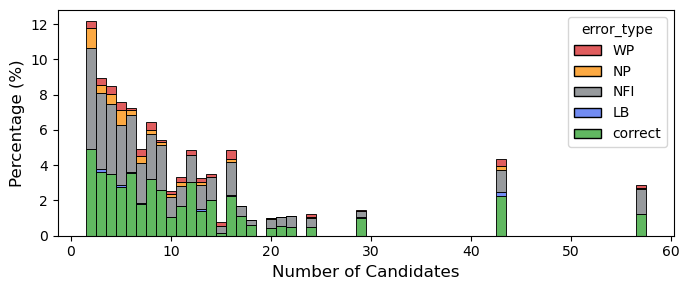

In [414]:
plot_stacked_error_by_num(df_elmke_mistralv2_term, "mistralv2 - term", stat='percent')

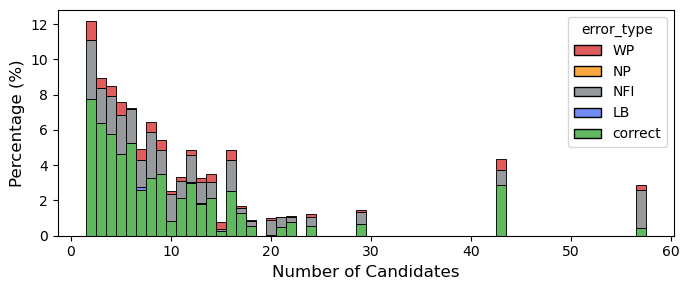

In [415]:
plot_stacked_error_by_num(df_elmke_mistralv3_term, "mistralv3 - term", stat='percent')

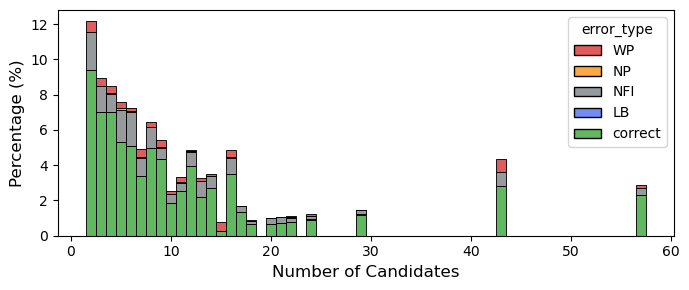

In [416]:
plot_stacked_error_by_num(df_elmke_llama3_term, "llama3 - term", stat='percent')

In [249]:
errors_mistralv2_term = [{'fn': 25, 'nfi': 133, 'lb': 2, 'tn': 49},
    {'fn': 23, 'nfi': 127, 'lb': 0, 'tn': 26},
    {'fn': 29, 'nfi': 135, 'lb': 2, 'tn': 31},
    {'fn': 19, 'nfi': 181, 'lb': 0, 'tn': 42},
    {'fn': 27, 'nfi': 173, 'lb': 2, 'tn': 36}]

In [248]:
errors_mistralv3_term = [{'fn': 0, 'nfi': 72, 'lb': 1, 'tn': 80},
    {'fn': 1, 'nfi': 66, 'lb': 0, 'tn': 63},
    {'fn': 2, 'nfi': 68, 'lb': 1, 'tn': 43},
    {'fn': 3, 'nfi': 82, 'lb': 0, 'tn': 126},
    {'fn': 3, 'nfi': 94, 'lb': 0, 'tn': 91}]

In [250]:
errors_llamav3_term = [{'fn': 2, 'nfi': 59, 'lb': 0, 'tn': 49},
    {'fn': 2, 'nfi': 31, 'lb': 1, 'tn': 32},
    {'fn': 3, 'nfi': 55, 'lb': 0, 'tn': 38},
    {'fn': 1, 'nfi': 54, 'lb': 0, 'tn': 43},
    {'fn': 3, 'nfi': 70, 'lb': 0, 'tn': 51}]

In [261]:
def reorg_df(results_file, have_inst = False):
    df_list = []
    
    results = reload_vars(results_file)
    
    for filename in results.keys():
        fullpath = f'data/vars/{filename}'   
        df_test = reload_vars(fullpath)    
    
        for idx, elem in enumerate(zip(results[filename]['test_results'], results[filename]['raw_answers'])):
            #print(fullpath)
            #print(elem)
            code = "_".join(fullpath.split('_')[3:5])
            #print(code)

            jd = None
            cos_sim = None
            if elem[0].get('is_correct', False):
                jd = elem[0].get('jd', 0)
                cos_sim = float(elem[0].get('cos_sim', 0))

            answer = elem[1][2]
            if have_inst:                
                answer = answer.split('[/INST] ')[-1][:-4] #-4 - remove trailing '</s>'

            term = df_test[idx]['term']
            candidates = get_choices(term, gt_dict)
                
            row = {
                'file': code,
                'idx': elem[0].get('idx', idx),
                'is_correct': elem[0].get('is_correct', False), 
                'gt': elem[0].get('gt', False),
                'pred': answer,
                'jd':jd,
                'cos_sim': cos_sim,
                'error_type': elem[0].get('error_type', None),
                'term': term,
                'candidates': candidates
            }

            #print(json.dumps(row, indent=4))

            df_list.append(row)
            #break
        #break 

    results_filename = results_file.split('/')[-1]
    df_file = "/".join(results_file.split('/')[:-1]) + '/df_' + results_filename
    
    df_flattened = pd.DataFrame(df_list)
    
    #pkl_vars(df_list, df_file)
    return df_flattened

In [258]:
def get_choices(term, kb):
    choices = list()
    for idx, choice in enumerate(kb[term]):
        #text = f'{idx+1}. {choice.split(":")[-1]}'        
        text = f'{choice.split(":")[-1]}'        
        choices.append(text)
    
    return choices    
    
gt_dict = reload_vars('data/vars/def_disamb_kb.pkl')

get_choices("Boundary", gt_dict)

['Boundary (Geometry)', 'Boundary (Topology)', 'Boundary (Graph Theory)']

In [262]:
df_mistralv3 = reorg_df('data/vars/elmke_mistralv3_20250311.pkl')
df_mistralv3

,file,idx,is_correct,gt,pred,jd,cos_sim,error_type,term,candidates
0,candi_1,0,False,Generalized Sum/Absolute Net Convergence,Absolutely Convergent Generalized Sum/Absolute...,NaN,NaN,nfi,Absolute,"[Absolute Number, Constant, Absolute Value, Ab..."
1,candi_1,1,True,Retract (Topology)/Absolute,'Retract (Topology)/Absolute',0.0,0.0,None,Absolute,"[Absolute Number, Constant, Absolute Value, Ab..."
2,candi_1,2,False,Error/Absolute,'Absolute Error',NaN,NaN,nfi,Absolute,"[Absolute Number, Constant, Absolute Value, Ab..."
3,candi_1,3,False,Frequency (Descriptive Statistics),The correct definition title is 'Frequency (De...,NaN,NaN,nfi,Absolute,"[Absolute Number, Constant, Absolute Value, Ab..."
4,candi_1,4,True,Absolute Measure of Dispersion,'Absolute Measure of Dispersion',0.0,0.0,None,Absolute,"[Absolute Number, Constant, Absolute Value, Ab..."
...,...,...,...,...,...,...,...,...,...,...
4071,term_5,418,True,Word (Formal Systems),'Word (Formal Systems)',0.0,0.0,None,Word,"[Word (Abstract Algebra), Ordered Tuple, Group..."
4072,term_5,419,True,Word (Natural Language),'Word (Natural Language)',0.0,0.0,None,Word,"[Word (Abstract Algebra), Ordered Tuple, Group..."
4073,term_5,420,False,Word Metric,Group Word Metric,NaN,NaN,fn,Word,"[Word (Abstract Algebra), Ordered Tuple, Group..."
4074,term_5,421,True,Zero Locus of Set of Polynomials,'Zero Locus of Set of Polynomials',0.0,0.0,None,Zero Locus,"[Zero Locus of Set of Polynomials, Vanishing S..."


In [269]:
df_mistralv3['error_type'].value_counts()

error_type
fn     981
nfi    814
tn      11
Name: count, dtype: int64